In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

d:\OneDrive - Hemas Holdings\Desktop\Model\ENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PP

## DataSet

In [3]:
Data = pd.read_excel("Company Data.xlsx")
Data.to_csv("Company Data.csv", index=False)

In [4]:
Data = pd.read_csv("Company Data.csv")
Data.head()

,Month,Year,Month_Number,ItemCode,Secondary_Sales_Qty,Free_Qty,Primary_Sales_Qty,Available_Primary_Inventory_Qty,Blocked_Stock_Qty,Inspection_Stock_Qty,Total_Primary_Inventory_Qty,Distributor_Inventory_Qty,Bonus_Flag,Supply_Constraint_Flag,Distributor_Buffer_Flag,Time_Index
0,2021-03,2021,3,600153,25.0,0.0,25.0,27.0,0.0,0.0,27.0,0,0,0,0,202103
1,2021-03,2021,3,600172,7.0,0.0,7.0,1.0,0.0,0.0,1.0,0,0,0,0,202103
2,2021-03,2021,3,600232,2.0,0.0,2.0,9.0,0.0,0.0,9.0,0,0,0,0,202103
3,2021-03,2021,3,600234,11.0,0.0,11.0,70.0,0.0,0.0,70.0,0,0,0,0,202103
4,2021-03,2021,3,600235,29.0,0.0,29.0,33.0,0.0,0.0,33.0,0,0,0,0,202103


In [5]:
Data.info()

<class 'pandas.DataFrame'>
RangeIndex: 149940 entries, 0 to 149939
Data columns (total 16 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Month                            149940 non-null  str    
 1   Year                             149940 non-null  int64  
 2   Month_Number                     149940 non-null  int64  
 3   ItemCode                         149940 non-null  int64  
 4   Secondary_Sales_Qty              149940 non-null  float64
 5   Free_Qty                         149940 non-null  float64
 6   Primary_Sales_Qty                149940 non-null  float64
 7   Available_Primary_Inventory_Qty  149940 non-null  float64
 8   Blocked_Stock_Qty                149940 non-null  float64
 9   Inspection_Stock_Qty             149940 non-null  float64
 10  Total_Primary_Inventory_Qty      149940 non-null  float64
 11  Distributor_Inventory_Qty        149940 non-null  int64  
 12  Bonus_Flag   

In [6]:
Data.count()

Month                              149940
Year                               149940
Month_Number                       149940
ItemCode                           149940
Secondary_Sales_Qty                149940
Free_Qty                           149940
Primary_Sales_Qty                  149940
Available_Primary_Inventory_Qty    149940
Blocked_Stock_Qty                  149940
Inspection_Stock_Qty               149940
Total_Primary_Inventory_Qty        149940
Distributor_Inventory_Qty          149940
Bonus_Flag                         149940
Supply_Constraint_Flag             149940
Distributor_Buffer_Flag            149940
Time_Index                         149940
dtype: int64

In [7]:
# Check Duplicates
dup_count = Data.duplicated().sum()
print(dup_count)

0


In [8]:
# Check Nulls
null_count = Data.isnull().sum()
print(null_count)

Month                              0
Year                               0
Month_Number                       0
ItemCode                           0
Secondary_Sales_Qty                0
Free_Qty                           0
Primary_Sales_Qty                  0
Available_Primary_Inventory_Qty    0
Blocked_Stock_Qty                  0
Inspection_Stock_Qty               0
Total_Primary_Inventory_Qty        0
Distributor_Inventory_Qty          0
Bonus_Flag                         0
Supply_Constraint_Flag             0
Distributor_Buffer_Flag            0
Time_Index                         0
dtype: int64


## Demand Signal Engineering

In [9]:
Data = Data.sort_values(["ItemCode", "Year", "Month_Number"])

# Rolling 3 month average
Data["Rolling3M_Avg"] = (Data.groupby("ItemCode")["Secondary_Sales_Qty"].transform(lambda x: x.rolling(3, min_periods=1).mean().shift(1)))

# Start with base demand
Data["Effective_Demand"] = Data["Secondary_Sales_Qty"]

# Bonus adjustment
Data.loc[Data["Bonus_Flag"] == 1, "Effective_Demand"] = (Data["Secondary_Sales_Qty"] - Data["Free_Qty"])

# Supply constraint adjustment (override)
Data.loc[Data["Supply_Constraint_Flag"] == 1, "Effective_Demand"] = (Data["Rolling3M_Avg"])

Data["Effective_Demand"] = Data["Effective_Demand"].clip(lower=0)

In [10]:
cap = Data["Effective_Demand"].quantile(0.995)
Data["Effective_Demand"] = np.minimum(Data["Effective_Demand"], cap)

## Demand Cleansing layer

In [11]:
# Rolling Base trend
Data["Rolling3M_Avg"] = (Data.groupby("ItemCode")["Effective_Demand"].transform(lambda x: x.rolling(3, min_periods=1).mean().shift(1)))

In [12]:
# Raw Demand
Data["Clean_Demand"] = Data["Effective_Demand"]

In [13]:
# Bonus intensity

Data["Bonus_Intensity"] = Data["Free_Qty"] / (Data["Effective_Demand"] + 1)

bonus_spike_condition = ((Data["Bonus_Flag"] == 1) & (Data["Effective_Demand"] > 1.5 * Data["Rolling3M_Avg"]))

Data.loc[bonus_spike_condition, "Clean_Demand"] = Data.loc[bonus_spike_condition, "Rolling3M_Avg"]

In [14]:
# Detect Inventory Shock

Data["Primary_Inv_Change"] = (Data.groupby("ItemCode")["Available_Primary_Inventory_Qty"].diff())

Data["Lag_Primary_Inv_Change"] = (Data.groupby("ItemCode")["Primary_Inv_Change"].shift(1))

In [15]:
# Stockout Drop Normalization
sales_drop_condition = ((Data["Effective_Demand"] < 0.6 * Data.groupby("ItemCode")["Effective_Demand"].shift(1)) &(Data["Lag_Primary_Inv_Change"] < 0))

Data.loc[sales_drop_condition, "Clean_Demand"] = Data.loc[sales_drop_condition, "Rolling3M_Avg"]

In [16]:
Data["Clean_Demand"] = Data["Clean_Demand"].clip(lower=0)

# Cap extreme outliers
cap = Data["Clean_Demand"].quantile(0.995)
Data["Clean_Demand"] = np.minimum(Data["Clean_Demand"], cap)

## Feature Engineering 

In [17]:
# Create Target Variable
Data["Target"] = (Data.groupby("ItemCode")["Clean_Demand"].shift(-1))

In [18]:
# Lag Features
for lag in [1, 2, 3, 6, 12]:
    Data[f"Lag{lag}"] = (
        Data.groupby("ItemCode")["Clean_Demand"].shift(lag)
    )

In [19]:
# Rolling Features
Data["Rolling3M_Mean"] = (Data.groupby("ItemCode")["Clean_Demand"].transform(lambda x: x.rolling(3).mean().shift(1)))

Data["Rolling6M_Mean"] = (Data.groupby("ItemCode")["Clean_Demand"].transform(lambda x: x.rolling(6).mean().shift(1)))

# Rolling Std (Volatility)
Data["Rolling3M_Std"] = (Data.groupby("ItemCode")["Clean_Demand"].transform(lambda x: x.rolling(3).std().shift(1)))
Data["Rolling3M_Std"] = Data["Rolling3M_Std"].clip(upper=Data["Rolling3M_Std"].quantile(0.99))

In [20]:
# Momentum Feature
Data["Momentum"] = Data["Lag1"] - Data["Lag3"]

In [21]:
# Seasonality Encoding
Data["Month_Sin"] = np.sin(2 * np.pi * Data["Month_Number"]/12)
Data["Month_Cos"] = np.cos(2 * np.pi * Data["Month_Number"]/12)

In [22]:
# Inventory Pressure Feature
Data["Inventory_Pressure"] = np.where(
    Data["Lag1"] == 0,
    0,
    Data["Available_Primary_Inventory_Qty"] / Data["Lag1"]
)

In [23]:
# Drop NaNs
Required_cols = ["Target", "Lag1", "Lag2", "Lag3", "Lag6", "Lag12", "Rolling3M_Mean", "Rolling6M_Mean", "Rolling3M_Std"]

Data = Data.dropna(subset=Required_cols).copy()

## Data Distribution

In [24]:
Data.count()

Month                              107799
Year                               107799
Month_Number                       107799
ItemCode                           107799
Secondary_Sales_Qty                107799
Free_Qty                           107799
Primary_Sales_Qty                  107799
Available_Primary_Inventory_Qty    107799
Blocked_Stock_Qty                  107799
Inspection_Stock_Qty               107799
Total_Primary_Inventory_Qty        107799
Distributor_Inventory_Qty          107799
Bonus_Flag                         107799
Supply_Constraint_Flag             107799
Distributor_Buffer_Flag            107799
Time_Index                         107799
Rolling3M_Avg                      107799
Effective_Demand                   107799
Clean_Demand                       107799
Bonus_Intensity                    107799
Primary_Inv_Change                 107799
Lag_Primary_Inv_Change             107799
Target                             107799
Lag1                              

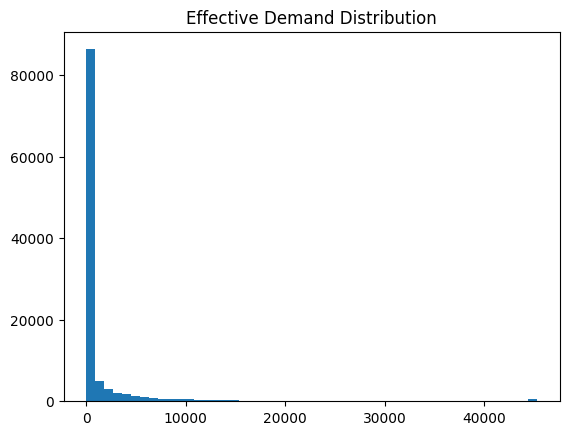

In [ ]:
# Overall Distribution
plt.figure()
plt.hist(Data["Clean_Demand"], bins=50)
plt.title("Effective Demand Distribution")
plt.show()

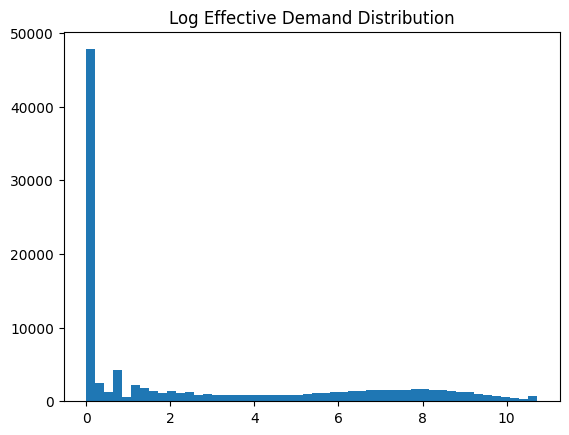

In [26]:
# Log Distribution
plt.figure()
plt.hist(np.log1p(Data["Clean_Demand"]), bins=50)
plt.title("Log Effective Demand Distribution")
plt.show()

In [27]:
print("Skewness:", Data["Clean_Demand"].skew())
print("Kurtosis:", Data["Clean_Demand"].kurt())

Skewness: 5.641937508676417
Kurtosis: 37.38988865880421


In [28]:
zero_ratio = (Data["Clean_Demand"]==0).mean()
print("Zero Demand Ratio:", zero_ratio)

Zero Demand Ratio: 0.44263861445839014


In [29]:
zero_ratio = (Data["Target"] == 0).mean()
print(zero_ratio)

0.44692436850063544


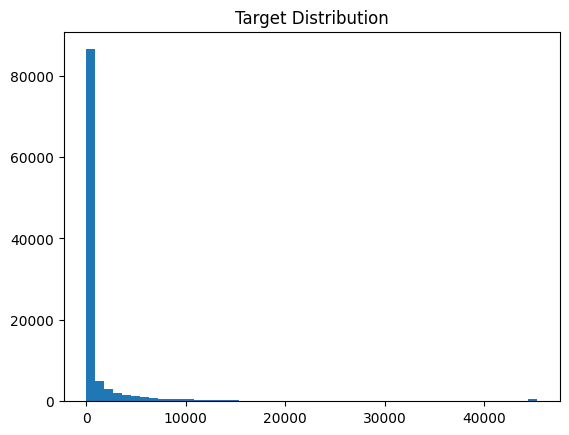

Target Skewness: 5.641514679090274


In [30]:
plt.figure()
plt.hist(Data["Target"], bins=50)
plt.title("Target Distribution")
plt.show()

print("Target Skewness:", Data["Target"].skew())

In [31]:
q99 = Data["Clean_Demand"].quantile(0.99)

print("99th percentile:", q99)
print("Max Demand:", Data["Clean_Demand"].max())

99th percentile: 28790.50666666677
Max Demand: 45311.11999999998


In [32]:
sku_status = Data.groupby("ItemCode")["Clean_Demand"].agg(["mean", "std", "max", "min", "count"])
print(sku_status.describe())

               mean           std           max           min        count
count   2750.000000   2736.000000   2750.000000   2750.000000  2750.000000
mean    1333.235286    478.982338   2539.210489    492.541920    39.199636
std     4563.714217   1464.019164   7285.402379   2488.260304    12.186877
min        0.000000      0.000000      0.000000      0.000000     1.000000
25%        0.055851      0.174983      1.000000      0.000000    38.000000
50%        2.400963      2.801482     12.000000      0.000000    45.500000
75%      328.157801    205.389567    996.250000      0.333333    47.000000
max    45311.120000  19649.769323  45311.120000  45311.120000    47.000000


# Modelling

In [33]:
# Define features & Target
feature_cols = [
    "Lag1","Lag2","Lag3","Lag6","Lag12",
    "Rolling3M_Mean","Rolling6M_Mean","Rolling3M_Std",
    "Momentum",
    "Month_Sin","Month_Cos",
    "Inventory_Pressure", "Bonus_Flag", "Supply_Constraint_Flag"
]

X = Data[feature_cols]
y = Data["Target"]

In [34]:
def sanitize(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    return df

## Base Architecture

In [35]:
# Train Test Split
train = Data[Data["Year"] < 2025]
test = Data[Data["Year"] >= 2025]

X_train = train[feature_cols]
y_train = train["Target"]

X_test = test[feature_cols]
y_test = test["Target"]

In [36]:
X_train = sanitize(X_train)
X_test  = sanitize(X_test)
y_train = np.nan_to_num(y_train)
y_test  = np.nan_to_num(y_test)

In [37]:
model = xgb.XGBRegressor(
    objective='reg:tweedie',
    tweedie_variance_power=1.4,
    eval_metric='rmse',
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,      # L1
    reg_lambda=5.0,     # L2
    random_state=42,
    early_stopping_rounds=50
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:tweedie'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.8
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_method=""hi

In [38]:
y_pred = model.predict(X_test)

In [39]:
def safe_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

wmape = np.sum(np.abs(y_test - y_pred)) / np.sum(y_test) * 100
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

avg = y_test.mean()

print("MAE:", mae)
print("RMSE:", rmse)
print("WMAPE:", wmape)
print("Average:", avg)

MAE: 276.17623775177333
RMSE: 1282.419911584803
WMAPE: 20.659276322540503
Average: 1336.8146755965918


### Visualize

<Figure size 800x600 with 0 Axes>

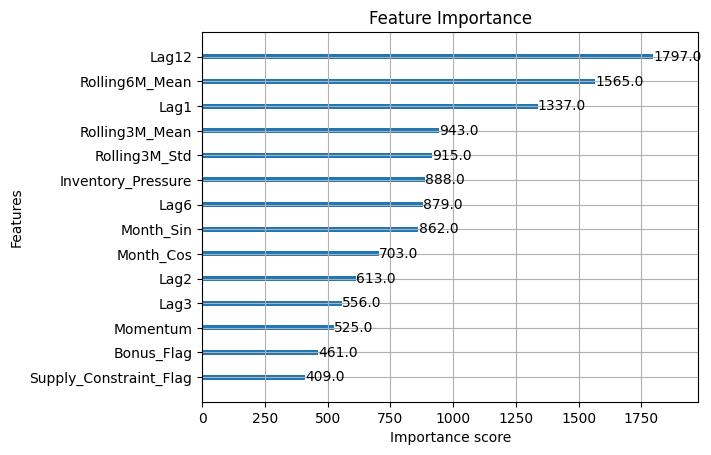

In [43]:
plt.figure(figsize=(8,6))
xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

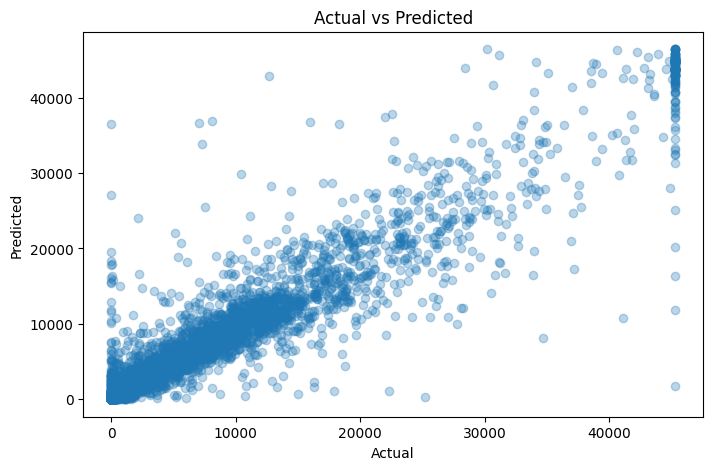

In [44]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

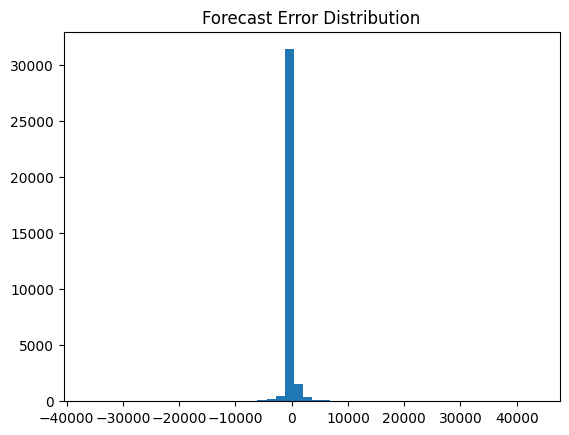

In [45]:
errors = y_test - y_pred
plt.hist(errors, bins=50)
plt.title("Forecast Error Distribution")
plt.show()

## Cross Validation

In [46]:
years = sorted(Data["Year"].unique())
results = []

for split_year in [2023, 2024]:

    train = Data[Data["Year"] <= split_year]
    test = Data[Data["Year"] == split_year + 1]

    X_train = train[feature_cols]
    y_train = train["Target"]

    X_test = test[feature_cols]
    y_test = test["Target"]

    model_cross = xgb.XGBRegressor(
    objective='reg:tweedie',
    tweedie_variance_power=1.4,
    eval_metric='rmse',
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,      
    reg_lambda=5.0,     
    random_state=42,
    early_stopping_rounds=50
)

    model_cross.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose = False)

    y_pred = model_cross.predict(X_test)

    wmape = np.sum(np.abs(y_test - y_pred)) / np.sum(y_test) * 100
    results.append((split_year, wmape))

print(results)

[(2023, np.float64(20.810349984571474)), (2024, np.float64(20.940688560965683))]


## Tunning

In [47]:
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

In [48]:
# Walk-forward split
train_tune = Data[Data["Year"] <= 2023]
valid_tune = Data[Data["Year"] == 2024]

X_train_tune = train_tune[feature_cols]
y_train_tune = train_tune["Target"]

X_valid_tune = valid_tune[feature_cols]
y_valid_tune = valid_tune["Target"]

X_train_tune = sanitize(X_train_tune)
X_valid_tune = sanitize(X_valid_tune)

def objective(trial):

    params = {
        "objective": "reg:tweedie",
        "eval_metric": "rmse",
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1.2, 1.55),
        "n_estimators": trial.suggest_int("n_estimators", 600, 1400),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.06),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 6),
        "subsample": trial.suggest_float("subsample", 0.75, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.75, 0.9),
        "gamma": trial.suggest_float("gamma", 0, 0.3),
        "reg_lambda": trial.suggest_float("reg_lambda", 2, 12),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 3),
        "random_state": 42,
        "early_stopping_rounds": 50
    }

    model = xgb.XGBRegressor(**params)

    model.fit(
        X_train_tune,
        y_train_tune,
        eval_set=[(X_valid_tune, y_valid_tune)],
        verbose=False
    )

    preds = model.predict(X_valid_tune)

    return wmape(y_valid_tune.values, preds)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

print("Best Params:", study.best_params)
print("Best Validation WMAPE:", study.best_value)

[I 2026-02-18 15:32:10,569] A new study created in memory with name: no-name-d8a99fcc-0c6b-4192-9210-63f34e71c811
[I 2026-02-18 15:32:13,080] Trial 0 finished with value: 20.650682965203373 and parameters: {'tweedie_variance_power': 1.4617754633790874, 'n_estimators': 1373, 'learning_rate': 0.04089220542833814, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.8413915861983772, 'colsample_bytree': 0.8005828741097816, 'gamma': 0.2974178568709143, 'reg_lambda': 9.154594579336516, 'reg_alpha': 0.21644359970678706}. Best is trial 0 with value: 20.650682965203373.
[I 2026-02-18 15:32:15,077] Trial 1 finished with value: 20.959907153049652 and parameters: {'tweedie_variance_power': 1.3135571987895922, 'n_estimators': 835, 'learning_rate': 0.03294005614911388, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.892669906728089, 'colsample_bytree': 0.8271787230175758, 'gamma': 0.24923827569603746, 'reg_lambda': 2.8692365721028095, 'reg_alpha': 2.7038672228736926}. Best is trial 0 with va

Best Params: {'tweedie_variance_power': 1.3654177988267255, 'n_estimators': 1089, 'learning_rate': 0.0533449528087719, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.8750208810556211, 'colsample_bytree': 0.8821803946127067, 'gamma': 0.27847994302554246, 'reg_lambda': 6.986599193196264, 'reg_alpha': 2.108230749213868}
Best Validation WMAPE: 20.39771401060763


In [49]:
best_params = study.best_params

final_model = xgb.XGBRegressor(objective="reg:tweedie", eval_metric="rmse", **best_params)

train_final = Data[Data["Year"] < 2025]
test_final = Data[Data["Year"] >= 2025]

X_train_final = sanitize(train_final[feature_cols])
y_train_final = train_final["Target"]

X_test_final = sanitize(test_final[feature_cols])
y_test_final = test_final["Target"]

final_model.fit(X_train_final, y_train_final)

y_pred_final = final_model.predict(X_test_final)

print("Final Test WMAPE:", wmape(y_test_final.values, y_pred_final))

Final Test WMAPE: 21.697007497401422


In [50]:
xgb.__version__

'3.2.0'

## 2-Staged

In [51]:
Data["HasDemand"] = (Data["Target"] > 0).astype(int)

train = Data[Data["Year"] < 2025]
test = Data[Data["Year"] >= 2025]

X_train = sanitize(train[feature_cols])
X_test = sanitize(test[feature_cols])

y_train_clf = train["HasDemand"]
y_train_reg = train["Target"]
y_test = test["Target"]

In [52]:
# Stage 1 - Classifier
clf_model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.85,
    colsample_bytree=0.8,
    random_state=42
)

clf_model.fit(X_train, y_train_clf)

prob_demand = clf_model.predict_proba(X_test)[:, 1]

In [53]:
# Stage 2 - Regression (non-zero only)
nonzero_train = train[train["Target"] > 0]

X_train_reg = sanitize(nonzero_train[feature_cols])
y_train_reg = nonzero_train["Target"]

reg_model = xgb.XGBRegressor(
    objective="reg:tweedie",
    tweedie_variance_power=1.3,
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.85,
    colsample_bytree=0.8,
    random_state=42
)

reg_model.fit(X_train_reg, y_train_reg)

pred_reg = reg_model.predict(X_test)

In [54]:
# Combine
final_pred = prob_demand * pred_reg

print("Two-Stage Test WMAPE:", wmape(y_test.values, final_pred))

Two-Stage Test WMAPE: 21.32089119484018


# Sv

In [ ]:
import joblib
joblib.dump(model, "model.pkl")